# Extract MILC output with python script
Averaging over multiple runs to get uncertainty

Sept 29, 2023


## Description of columns in parse script : 



- Solve time =  2 x sum of all mass-solve times


- quda-total-time = solve-time + mg-setup + epsilon

- summed_time = quda_total_time + contractions + epsilon

- milc_total_time = summed_time + err

In [1]:
! hostname

jupyter-venkitesh


In [2]:
import os, glob
import subprocess as sp
import numpy as np
import shutil

import re

import pandas as pd

import matplotlib.pyplot as plt
from ipywidgets import *
import seaborn as sns

import itertools

import gvar as gv

In [3]:
from python_parse import *

In [4]:
%matplotlib widget

In [5]:
top_dir='/gpfs/alpine/lgt104/proj-shared/ayyar/runs_frontier/runs_jan27_2023'

runs_lst=[
['cg_144_1','cg_split','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/cg_all/output-cg_1.kpp'],
['cg_144_2','cg_split','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/cg_all/output-cg_2.kpp'],
['cg_144_3','cg_split','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/cg_all/output-cg_3.kpp'],
['cg_144_4','cg_split','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/cg_all/output-cg_4.kpp'],
['cg_144_5','cg_split','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/cg_all/output-cg_5.kpp'],
['cg_144_6','cg_split','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/cg_all/output-cg_6.kpp'],

['mg_144_1','mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_1-2/output-full_1.kpp'],
['mg_144_2','mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_1-2/output-full_2.kpp'],
['mg_144_3','mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_1-2/output-full_3.kpp'],
['mg_144_4','mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_1-2/output-full_4.kpp'],
['mg_144_5','mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_1-2/output-full_5.kpp'],
['mg_144_6','mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_1-2/output-full_6.kpp'],

['mg_144_3-4light_1'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_3-4/output-full_1.kpp'],
['mg_144_3-4light_2'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_3-4/output-full_2.kpp'],
['mg_144_3-4light_3'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_3-4/output-full_3.kpp'],
['mg_144_3-4light_4'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_3-4/output-full_4.kpp'],

['mg_144_5-6light_1'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_5-6/output-full_1.kpp'],
['mg_144_5-6light_2'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_5-6/output-full_2.kpp'],
['mg_144_5-6light_3'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_5-6/output-full_3.kpp'],
['mg_144_5-6light_4'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_5-6/output-full_4.kpp'],

['mg_144_7-8light_1'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_7-8/output-full_1.kpp'],
['mg_144_7-8light_2'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_7-8/output-full_2.kpp'],
['mg_144_7-8light_3'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_7-8/output-full_3.kpp'],
['mg_144_7-8light_4'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_7-8/output-full_4.kpp'],

['mg_144_9-10light_1'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_9-10/output-full_1.kpp'],
['mg_144_9-10light_2'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_9-10/output-full_2.kpp'],
['mg_144_9-10light_3'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_9-10/output-full_3.kpp'],
['mg_144_9-10light_4'  ,'mg','/autofs/nccs-svm1_home1/venkitesh/mg_output_files/10_split_mass/light_mass_9-10/output-full_4.kpp'],

]


In [6]:
## Parse output files

df_data=pd.DataFrame([])

op_files=[]
for count,i in enumerate(runs_lst):    
    # print(i)
    mlight=2 if count>11 else 10
    mmulti=8 if count>11 else 0
    dict1 = f_extract(fname=i[2],run_type=i[1],m_light=mlight, m_multi=mmulti, m_heavy=10)
    dict1['name']=i[0]
    
    # f_print_dict(dict1)
    
    df_data=pd.concat([df_data,pd.DataFrame(dict1,index=[count])])
    count+=1


120
120
120
120
120
120


In [9]:
# df_data

In [8]:
df_data[[i for i in df_data.columns if i.startswith('mass')]]

,mass-01,mass-02,mass-03,mass-04,mass-05,mass-06,mass-07,mass-08,mass-09,mass-10,mass-11-20,mass-01-10,mass-03-10
0,113.006390,65.740750,47.692905,44.067570,43.515251,29.131094,23.016656,15.945133,15.462891,12.680299,59.571659,410.258939,NaN
1,93.328395,63.844910,46.298924,42.788607,42.242176,28.280019,22.339446,15.470189,15.002822,12.305055,57.886911,381.900543,NaN
2,92.057240,62.946390,45.655233,42.184292,41.649916,27.881560,22.037485,15.273115,14.811545,12.148438,57.262668,376.645216,NaN
3,92.561735,62.927555,46.157216,51.249286,41.635448,27.888438,32.888516,22.446950,14.817465,14.442532,59.916073,407.015142,NaN
4,102.406545,69.842370,50.713764,45.611530,46.132192,31.874680,23.989068,15.951002,16.388887,13.716952,62.762716,416.626989,NaN
5,94.372505,64.422815,46.724507,43.164169,42.625464,28.545654,22.561399,15.630904,15.144455,12.455377,58.478103,385.647250,NaN
6,28.614217,21.154911,21.057078,24.899024,34.496870,48.983990,68.875325,92.745335,142.937670,167.364075,68.248357,651.128496,NaN
7,26.444628,19.213769,21.556784,26.775707,34.966525,49.852900,69.753320,94.938480,142.148995,170.572915,66.466271,656.224023,NaN
8,27.107502,18.709239,18.669705,24.341126,32.401460,42.655435,57.754900,77.050600,116.859570,140.190585,66.921384,555.740123,NaN
9,26.255502,19.067295,21.571563,25.520215,34.389465,49.551440,69.311060,94.277780,141.156745,172.036485,65.581105,653.137550,NaN


In [13]:
df_avg=pd.DataFrame([])
dict1={}

df_temp=df_data.iloc[:6]
df_temp=df_temp.drop(columns=['name'])

dict1['name']='cg'
for col in df_temp.columns:
    dict1[col]=gv.dataset.avg_data(df_temp[col].values)

df_avg=pd.concat([df_avg,pd.DataFrame(dict1,index=[df_avg.shape[0]+1])])


df_temp=df_data.iloc[6:12]
df_temp=df_temp.drop(columns=['name'])

dict1['name']='mg'
for col in df_temp.columns:
    dict1[col]=gv.dataset.avg_data(df_temp[col].values)

df_avg=pd.concat([df_avg,pd.DataFrame(dict1,index=[df_avg.shape[0]+1])])


df_temp=df_data.iloc[12:16]
df_temp=df_temp.drop(columns=['name'])

dict1['name']='mg_3-4'
for col in df_temp.columns:
    dict1[col]=gv.dataset.avg_data(df_temp[col].values)

df_avg=pd.concat([df_avg,pd.DataFrame(dict1,index=[df_avg.shape[0]+1])])


df_temp=df_data.iloc[16:20]
df_temp=df_temp.drop(columns=['name'])

dict1['name']='mg_5-6'
for col in df_temp.columns:
    dict1[col]=gv.dataset.avg_data(df_temp[col].values)

df_avg=pd.concat([df_avg,pd.DataFrame(dict1,index=[df_avg.shape[0]+1])])

df_temp=df_data.iloc[20:24]
df_temp=df_temp.drop(columns=['name'])

dict1['name']='mg_7-8'
for col in df_temp.columns:
    dict1[col]=gv.dataset.avg_data(df_temp[col].values)

df_avg=pd.concat([df_avg,pd.DataFrame(dict1,index=[df_avg.shape[0]+1])])

df_temp=df_data.iloc[24:28]
df_temp=df_temp.drop(columns=['name'])

dict1['name']='mg_9-10'
for col in df_temp.columns:
    dict1[col]=gv.dataset.avg_data(df_temp[col].values)

df_avg=pd.concat([df_avg,pd.DataFrame(dict1,index=[df_avg.shape[0]+1])])


df_avg

,name,startup,loading,mg-setup,mass-01,mass-02,mass-03,mass-04,mass-05,mass-06,...,mass-11-20,mass-01-10,make/save-src,contractions,quda-total-time,milc-total-time,solve-time,summed-time,error,mass-03-10
1,cg,30.53(83),644(11),0(0),98.0(3.1),64.95(97),47.21(69),44.8(1.3),42.97(63),28.93(56),...,59.31(73),396.3(6.3),25.8(3.0),93.0(3.5),938(23),1726(24),911(14),1704(21),22.0(3.0),nan +- nan
2,mg,30.46(28),630.9(2.4),2176(27),26.82(35),19.60(35),20.98(43),25.58(33),34.04(35),48.6(1.1),...,66.40(40),633(15),22.710(27),90.2(3.2),3584(39),4365(40),1399(29),4349(40),15.73(24),nan +- nan
3,mg_3-4,30.41(42),627.47(51),1834.3(5.2),16.91(37),16.344(44),nan +- nan,nan +- nan,nan +- nan,nan +- nan,...,66.87(49),195.92(48),22.686(34),78.8(1.1),2370.2(4.6),3136.6(4.8),525.6(1.8),3119.3(4.8),17.356(15),162.66(72)
4,mg_5-6,30.4(1.0),630.83(80),1889(14),16.94(43),14.753(23),nan +- nan,nan +- nan,nan +- nan,nan +- nan,...,66.58(45),200.0(1.7),22.763(72),89.9(3.8),2434(11),3213(15),533.2(4.3),3196(15),17.413(53),168.3(1.4)
5,mg_7-8,29.80(57),628.82(49),1386.7(2.5),12.085(65),11.930(38),nan +- nan,nan +- nan,nan +- nan,nan +- nan,...,65.82(45),190.3(1.6),22.855(95),89.9(3.9),1909.9(6.2),2687.7(4.7),512.3(4.1),2670.3(4.7),17.322(26),166.3(1.6)
6,mg_9-10,30.05(92),629.8(2.5),1618(17),10.91(39),10.149(28),nan +- nan,nan +- nan,nan +- nan,nan +- nan,...,67.24(62),186.24(77),22.805(93),90.0(3.8),2136(16),2915(14),507.0(2.8),2898(14),17.241(21),165.2(1.0)


In [14]:
# for rows after 3, the mass index is wrong, fix it 

df_avg.loc[3,'mass-03']=df_avg[df_avg.name=='mg_3-4'].loc[3,'mass-01']
df_avg.loc[3,'mass-04']=df_avg[df_avg.name=='mg_3-4'].loc[3,'mass-02']

df_avg.loc[3,'mass-01']=gv.gvar(np.nan,np.nan)
df_avg.loc[3,'mass-02']=gv.gvar(np.nan,np.nan)

df_avg.loc[4,'mass-05']=df_avg[df_avg.name=='mg_5-6'].loc[4,'mass-01']
df_avg.loc[4,'mass-06']=df_avg[df_avg.name=='mg_5-6'].loc[4,'mass-02']

df_avg.loc[4,'mass-01']=gv.gvar(np.nan,np.nan)
df_avg.loc[4,'mass-02']=gv.gvar(np.nan,np.nan)

df_avg.loc[5,'mass-07']=df_avg[df_avg.name=='mg_7-8'].loc[5,'mass-01']
df_avg.loc[5,'mass-08']=df_avg[df_avg.name=='mg_7-8'].loc[5,'mass-02']

df_avg.loc[5,'mass-01']=gv.gvar(np.nan,np.nan)
df_avg.loc[5,'mass-02']=gv.gvar(np.nan,np.nan)

df_avg.loc[6,'mass-09']=df_avg[df_avg.name=='mg_9-10'].loc[6,'mass-01']
df_avg.loc[6,'mass-10']=df_avg[df_avg.name=='mg_9-10'].loc[6,'mass-02']

df_avg.loc[6,'mass-01']=gv.gvar(np.nan,np.nan)
df_avg.loc[6,'mass-02']=gv.gvar(np.nan,np.nan)

df_avg[[i for i in df_data.columns if i.startswith('mass')]]

,mass-01,mass-02,mass-03,mass-04,mass-05,mass-06,mass-07,mass-08,mass-09,mass-10,mass-11-20,mass-01-10,mass-03-10
1,98.0(3.1),64.95(97),47.21(69),44.8(1.3),42.97(63),28.93(56),24.5(1.6),16.8(1.0),15.27(22),12.96(34),59.31(73),396.3(6.3),nan +- nan
2,26.82(35),19.60(35),20.98(43),25.58(33),34.04(35),48.6(1.1),70.1(3.2),90.1(2.6),135.5(3.9),161.6(4.9),66.40(40),633(15),nan +- nan
3,nan +- nan,nan +- nan,16.91(37),16.344(44),nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,66.87(49),195.92(48),162.66(72)
4,nan +- nan,nan +- nan,nan +- nan,nan +- nan,16.94(43),14.753(23),nan +- nan,nan +- nan,nan +- nan,nan +- nan,66.58(45),200.0(1.7),168.3(1.4)
5,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,12.085(65),11.930(38),nan +- nan,nan +- nan,65.82(45),190.3(1.6),166.3(1.6)
6,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,nan +- nan,10.91(39),10.149(28),67.24(62),186.24(77),165.2(1.0)


In [15]:
df_plot=pd.DataFrame([],columns=['name','mass','cg','mg'])

m_light=10
# mass values of the lightest 10 masses
masses = [0.000569, 0.0010, 0.001555, 0.00225, 0.00311, 0.004665, 0.00622, 0.00933, 0.01244, 0.01555]
light_masses=['mass-{:02d}'.format(count+1) for count in range(m_light)]

df_plot['name']= light_masses
df_plot['mass']=masses
df_plot['cg']=df_avg[df_avg.name=='cg'][['mass-{:02d}'.format(count+1) for count in range(m_light)]].values.tolist()[0]

df_plot['mg'] = [df_avg.iloc[1]['mass-01'], df_avg.iloc[1]['mass-02'],
df_avg.iloc[2]['mass-03'], df_avg.iloc[2]['mass-04'],
df_avg.iloc[3]['mass-05'], df_avg.iloc[3]['mass-06'],
df_avg.iloc[4]['mass-07'], df_avg.iloc[4]['mass-08'],
df_avg.iloc[5]['mass-09'], df_avg.iloc[5]['mass-10']]

df_plot

,name,mass,cg,mg
0,mass-01,0.000569,98.0(3.1),26.82(35)
1,mass-02,0.001000,64.95(97),19.60(35)
2,mass-03,0.001555,47.21(69),16.91(37)
3,mass-04,0.002250,44.8(1.3),16.344(44)
4,mass-05,0.003110,42.97(63),16.94(43)
5,mass-06,0.004665,28.93(56),14.753(23)
6,mass-07,0.006220,24.5(1.6),12.085(65)
7,mass-08,0.009330,16.8(1.0),11.930(38)
8,mass-09,0.012440,15.27(22),10.91(39)
9,mass-10,0.015550,12.96(34),10.149(28)


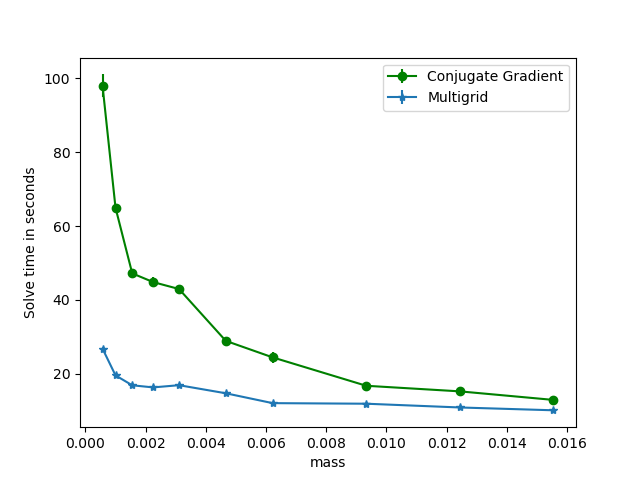

In [16]:
df=df_avg.copy()

plt.figure()

x=df_plot.mass.values
ya=df_plot.cg.values
yb=df_plot.mg.values

plt.errorbar(x,gv.mean(ya),gv.sdev(ya),marker='o', color='g', label='Conjugate Gradient')
plt.errorbar(x,gv.mean(yb),gv.sdev(yb), marker='*', label='Multigrid')

plt.ylabel("Solve time in seconds")
plt.xlabel("mass")
plt.legend(loc='best')
# plt.yscale('log')

plt.show()



In [17]:
# df=df_avg.copy()
# m_light=10
# light_mass_columns=['mass-{:02d}'.format(count+1) for count in range(m_light)] # keys for all light masses
# print(light_mass_columns)

# plt.figure()

# x=masses[:m_light]
# ya = df.iloc[0][light_mass_columns].values

# plt.errorbar(x,gv.mean(ya),gv.sdev(ya),marker='o', color='g', label='Conjugate Gradient')

# x=masses[:10]
# y1 = df.iloc[1][light_mass_columns].values[:2]
# y2=df_avg.iloc[2][light_mass_columns][2:4].values
# y3=df_avg.iloc[3][light_mass_columns][4:6].values
# y4=df_avg.iloc[4][light_mass_columns][6:8].values
# y5=df_avg.iloc[5][light_mass_columns][8:10].values

# # y=np.append(y1,y2)
# yb=np.stack([y1,y2,y3,y4,y5]).flatten()
# # yb=np.append(np.append(y1,y2),y3)

# plt.errorbar(x,gv.mean(yb),gv.sdev(yb), marker='*', label='Multigrid')

# plt.ylabel("Solve time in seconds")
# plt.xlabel("mass")
# plt.legend(loc='best')
# # plt.yscale('log')

# plt.show()

